
<a id='general-packages'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Pacotes de Uso Geral 

## Conteúdo 

- [Pacotes de Uso Geral](#Pacote-de-Uso-Geral)  
  - [Resumo](#Resumo)  
  - [Integração Númerica](#Integração-Númerica)  
  - [Interpolação](#Interpolação)  
  - [Álgebra Linear](#Álgebra-Linear)  
  - [Ferramentas Gerais](#Ferramentas-Gerais)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://quantecon.org/) pelos bolsistas CNPq, Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob supervisão do Prof. Christiano Penna, do CAEN/UFC.*

## Resumo

Julia possui um grande número de bibliotecas úteis e bem escritas e muitas provas de conceito incompletas e mal mantidas.

Uma grande vantagem das bibliotecas Julia é que, como o própria Julia é suficientemente rápido, há menos necessidade de misturar em linguagens de baixo nível como C e Fortran.

Como resultado, a maioria das bibliotecas Julia é escrita exclusivamente em Julia.

Isso não apenas torna as bibliotecas mais portáteis, como também as torna mais fáceis de explorar, ler, aprender e modificar.

Nesta aula, apresentamos algumas das bibliotecas Julia que consideramos particularmente úteis para o trabalho quantitativo em economia:

Veja também [pacotes estatísticos e de dados](https://lectures.quantecon.org/data_statistical_packages.html), além de [otimização, solução e pacotes relacionados](https://lectures.quantecon.org/optimization_solver_packages.html) para mais pacotes específicos de domínio.

### Configuração

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics
using QuantEcon, QuadGK, FastGaussQuadrature, Distributions, Expectations
using Interpolations, Plots, LaTeXStrings, ProgressMeter

## Integração Númerica

Muitas aplicações requerem o cálculo direto de uma derivada numérica e o cálculo de expectativas.

### Quadratura Adaptativa 

Uma solução de alta precisão para o cálculo de integrais numéricas é o [QuadGK](https://github.com/JuliaMath/QuadGK.jl).

In [3]:
using QuadGK
@show value, tol = quadgk(cos, -2π, 2π);

(value, tol) = quadgk(cos, -2π, 2π) = (-1.5474478810961125e-14, 5.7846097329025695e-24)


Esta é uma técnica de integração adaptativa de Gauss-Kronrod que é relativamente precisa para funções suaves.

No entanto, sua implementação adaptativa o torna lento e não é adequado para loops internos.

### Quadratura Gaussiana

Alternativamente, muitas integrais podem ser feitas eficientemente com [quadratura Gaussiana](https://en.wikipedia.org/wiki/Gaussian_quadrature) (não adaptativa).

Por exemplo, usando [FastGaussQuadrature.jl](https://github.com/ajt60gaibb/FastGaussQuadrature.jl).

In [4]:
using FastGaussQuadrature
x, w = gausslegendre( 100_000 ); # ou seja, encontre 100,000 nós

# integra f(x) = x^2 de -1 para 1
f(x) = x^2
@show w ⋅ f.(x); # calcular integral

w ⋅ f.(x) = 0.6666666666666667


O único problema com o pacote `FastGaussQuadrature` é que você precisará lidar com as transformações afins nos domínios não padrão.

Alternativamente, `QuantEcon.jl` possui rotinas para quadratura Gaussina que traduz o domínio.

In [5]:
using QuantEcon

x, w = qnwlege(65, -2π, 2π);
@show w ⋅ cos.(x); # ou seja, no [-2π, 2π] domínio

w ⋅ cos.(x) = -3.0064051806277455e-15


### Expectativas

Se os cálculos da integração numérica são simplesmente para calcular expectativas matemáticas de uma distribuição específica, então [Expectations.jl](https://github.com/QuantEcon/Expectations.jl) fornece uma interface conveniente.

Em outras palavras, ele encontra o esquema de quadratura Gaussiana apropriado para a distribuição usando `FastGaussQuadrature`.

In [6]:
using Distributions, Expectations
dist = Normal()
E = expectation(dist)
f(x) = x
@show E(f) #ou seja identidade

# Ou usando como um operador linear
f(x) = x^2
x = nodes(E)
w = weights(E)
E * f.(x) == f.(x) ⋅ w

E(f) = -6.991310601309959e-18


true

## Interpolação

Em economia, geralmente desejamos interpolar dados discretos (por exemplo, criar funções contínuas que juntam sequências discretas de pontos).

O pacote para o qual geralmente nos voltamos é [Interpolations.jl](https://github.com/JuliaMath/Interpolations.jl).

Existem várias opções, mas apenas demonstraremos as notações convenientes.

### Univariada com um *grid* Regular

Vamos começar com o caso univariado.

Começamos criando alguns pontos de dados, usando uma função *seno*.

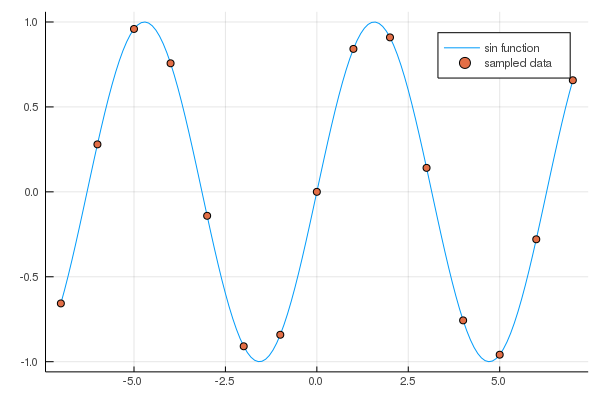

In [7]:
using Interpolations
using Plots
gr(fmt=:png);

x = -7:7 # pontos x, coase grid
y = sin.(x) # pontos y correspondentes

xf = -7:0.1:7        # bom grid
plot(xf, sin.(xf), label = "sin function")
scatter!(x, y, label = "sampled data", markersize = 4)

Implementar interpolação linear e cúbica de [spline](https://en.wikipedia.org/wiki/Spline_%28mathematics%29).

li(0.3) = 0.25244129544236954


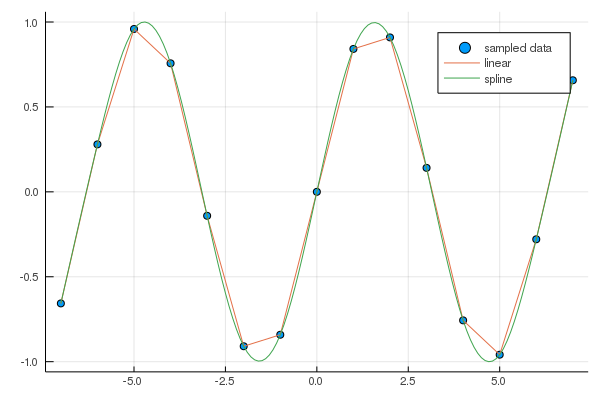

In [8]:
li = LinearInterpolation(x, y)
li_spline = CubicSplineInterpolation(x, y)

@show li(0.3) # avalie em um único ponto

scatter(x, y, label = "sampled data", markersize = 4)
plot!(xf, li.(xf), label = "linear")
plot!(xf, li_spline.(xf), label = "spline")

### Univariada com *Grid* Irregular

Acima, a função `LinearInterpolation` usa uma função especializada
para *grids* regulares pois `x` é um tipo `Range`.

Para um arbitrário e irregular *grid*.

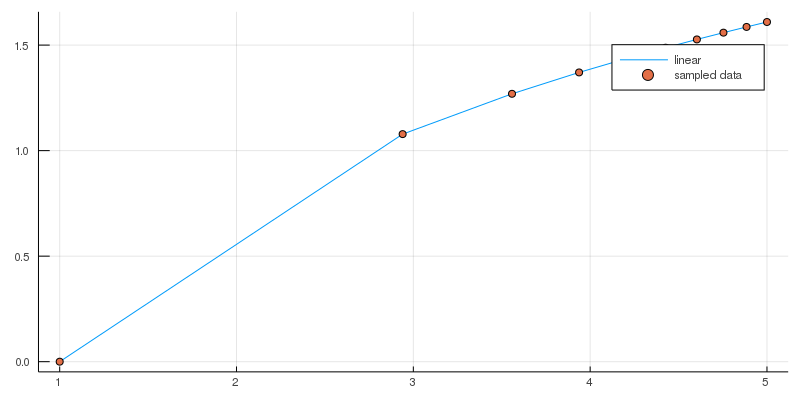

In [9]:
x = log.(range(1, exp(4), length = 10)) .+ 1  # irregular grid
y = log.(x) # pontos y correspondentes

interp = LinearInterpolation(x, y)

xf = log.(range(1,  exp(4), length = 100)) .+ 1 # melhor grid

plot(xf, interp.(xf), label = "linear")
scatter!(x, y, label = "sampled data", markersize = 4, size = (800, 400))

Neste ponto, `Interpolations.jl` não tem um suporte para splines cúbicos com *grids* irregulares, mas existem muitos outros pacotes que fazem (por exemplo, [Dierckx.jl](https://github.com/kbarbary/Dierckx.jl)  e [GridInterpolations.jl](https://github.com/sisl/GridInterpolations.jl)).

### Interpolação Multivariada

Interpolar uma função multivariada regular usa a mesma função:

In [10]:
f(x,y) = log(x+y)
xs = 1:0.2:5
ys = 2:0.1:5
A = [f(x,y) for x in xs, y in ys]

# linear interpolation
interp_linear = LinearInterpolation((xs, ys), A)
@show interp_linear(3, 2) # exatamente log(3 + 2)
@show interp_linear(3.1, 2.1) # aproximadamente log(3.1 + 2.1)

# interpolação de spline cúbico
interp_cubic = CubicSplineInterpolation((xs, ys), A)
@show interp_cubic(3, 2) # exatamente log(3 + 2)
@show interp_cubic(3.1, 2.1) # aproximadamente log(3.1 + 2.1);

interp_linear(3, 2) = 1.6094379124341003
interp_linear(3.1, 2.1) = 1.6484736801441782
interp_cubic(3, 2) = 1.6094379124341
interp_cubic(3.1, 2.1) = 1.6486586594237707


Veja [a documentação de Interpolations.jl](https://github.com/JuliaMath/Interpolations.jl#convenience-notation) para mais detalhes sobre opções e configuração.

## Álgebra Linear

### Biblioteca padrão

A biblioteca padrão contém muitas rotinas úteis para álgebra linear, para além das funções convencionais, tais como `det()`, `inv()`, `factorize()`, etc.

Rotinas estão disponíveis para:

- Fatoração de Cholesky.
- Decomposição LU.
- Decomposição de valor singular,,  
- Fatoração de Schur, etc..  


Veja [aqui](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/) para mais detalhes.

## Ferramentas Gerais

### LaTeXStrings.jl

Quando você precisar escapar adequadamente do código de látex (por exemplo, para rótulos de equações), use [LaTeXStrings.jl](https://github.com/stevengj/LaTeXStrings.jl).

In [11]:
using LaTeXStrings
L"an equation: $1 + \alpha^2$"

L"an equation: $1 + \alpha^2$"

### ProgressMeter.jl

Para operações de longa execução, você pode usar o pacote [ProgressMeter.jl](https://github.com/timholy/ProgressMeter.jl) 

Para usar o pacote, basta colocar um macro na frente dos `for` loops, etc.

A partir da documentação:

In [12]:
using ProgressMeter

@showprogress 1 "Computing..." for i in 1:50
    sleep(0.1) # alguma computação....
end

Computing...100%|███████████████████████████████████████| Time: 0:00:05
